In [111]:
import pandas as pd
import numpy as np
from datetime import datetime
import xml.etree.ElementTree as et
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

pd.options.mode.chained_assignment = None

In [112]:
plt.style.use('ggplot')

# Read in Data of Interest

In [113]:
train_datapath = '../../OhioT1DM/data/train/'
test_datapath = '../../OhioT1DM/data/test/'
processed = '../../OhioT1DM/data/processed/'
data_of_interest = [['GlucoseLevel','./glucose_level/event'],
                    ['Long', './basal/event'],
                    ['Short', './bolus/event'],
                    ['Carb', './meal/event']]
patients_of_interest = ['588', '570', '563']
access_values = {'GlucoseLevel': 'value', 'Long': 'value', 'Short': 'dose', 'Carb': 'carbs'}
min5nano = 5*60*1000000000

In [114]:
def read_all_patient_data(datapath):
    files = os.listdir(datapath)
    all_file_data = {}
    for k,filename in enumerate(files):
        patient_id = filename[0:3]
        if (patient_id not in patients_of_interest): 
            continue
        temp_data = {}
        for datapoint, xml_path in data_of_interest:
            data = pd.read_xml(datapath + filename, xpath=xml_path)
            time_col = 'ts'
            if 'ts' not in data:
                time_col = 'ts_begin'
            data['ts'] = pd.to_datetime(data[time_col], format='%d-%m-%Y %H:%M:%S')
            # Round to nearest 5 mins
            data['ts'] = pd.to_datetime(((data['ts'].astype(np.int64) // min5nano + 1 ) * min5nano))
            data = data.set_index('ts')
            data = data.groupby(level=0).sum(numeric_only=True)
            temp_data[datapoint] = data
        all_file_data[patient_id] = temp_data
    return all_file_data

all_training_data = read_all_patient_data(train_datapath)
all_testing_data = read_all_patient_data(test_datapath)

In [115]:
def parse_patient_data(patient_id):
    train_data = all_training_data[patient_id]
    test_data = all_testing_data[patient_id]
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()
    for j, key in enumerate(train_data):
        train_df[key] = train_data[key][access_values[key]]
        test_df[key] = test_data[key][access_values[key]]
    return train_df.fillna(0), test_df.fillna(0)

In [116]:
# Get 3 random patients of interest - 570, 588, 563
train_570, test_570 = parse_patient_data('570')

train_588, test_588 = parse_patient_data('588')

train_563, test_563 = parse_patient_data('563')

In [117]:
testing, testing2 = parse_patient_data('563')

# Define Equations for Absorption Curves

In [118]:
def short_acting_insulin_curve(size):
    """
    Take in next 96 datapoints for short acting insulin to work over
    """
    curve_points = np.zeros(96)
#     modifier = size / 63
    modifier = size / 2
    cur_size = size
    for i in range(0, 6, 1):
        curve_points[i] = 0.25 * modifier
        
    for j, i in enumerate(range(35, 120, 5)):
        val = (0.25 + (1 + (i-120)/90))
        curve_points[j+6] = val * modifier
        
    for j, i in enumerate(range(120, 240, 5)):
        val = (0.25 + (1 - 0.5*((i - 120) / 120)))
        curve_points[j+23] = val * modifier

    for j, i in enumerate(range(240, 485, 5)):
        val = (0.25 + 0.5 * (1 - (i - 240)/240))
        curve_points[j+47] = val * modifier

    return curve_points

In [119]:
def glucose_absorption_curve(size):
    """
    Creates a curve for glucose to be absorbed over
    """
    curve_points = np.zeros(48)
    modifier = size
    for j, i in enumerate(range(0, 15, 5)):
        val = 0.05 + 0.6 * i
        curve_points[j] = val * modifier
    
    for j, i in enumerate(range(15, 45, 5)):
        val = 0.05 + ((45 - i) / 6)
        curve_points[j+2] = val * modifier
        
    for i in range(8, 48):
        curve_points[i] = 0.05 * modifier
        
    return curve_points

In [120]:
insulin_curve = short_acting_insulin_curve(1)
carbohydrate_curve = glucose_absorption_curve(1)

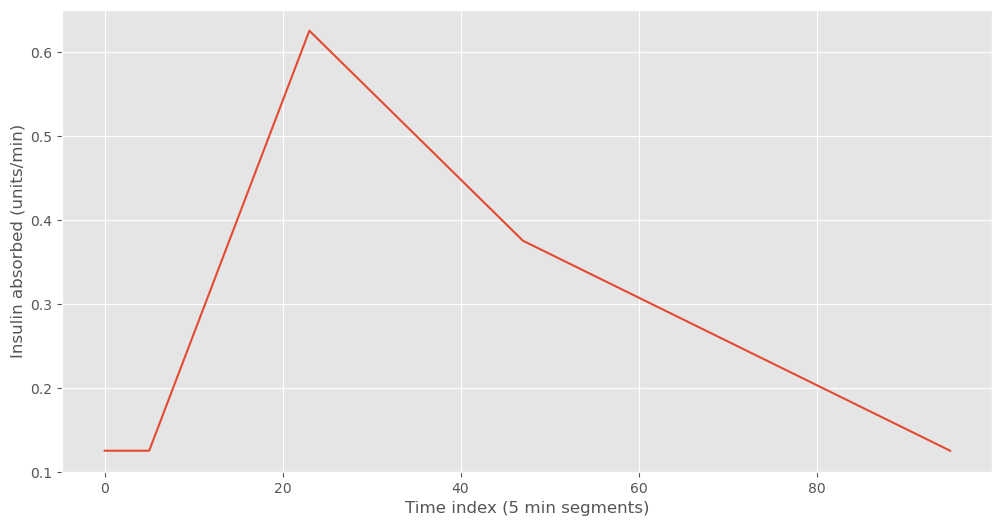

In [121]:
fig, ax = plt.subplots(figsize=(12,6))
plt.xlabel("Time index (5 min segments)")
plt.ylabel("Insulin absorbed (units/min)")
plt.plot(insulin_curve)

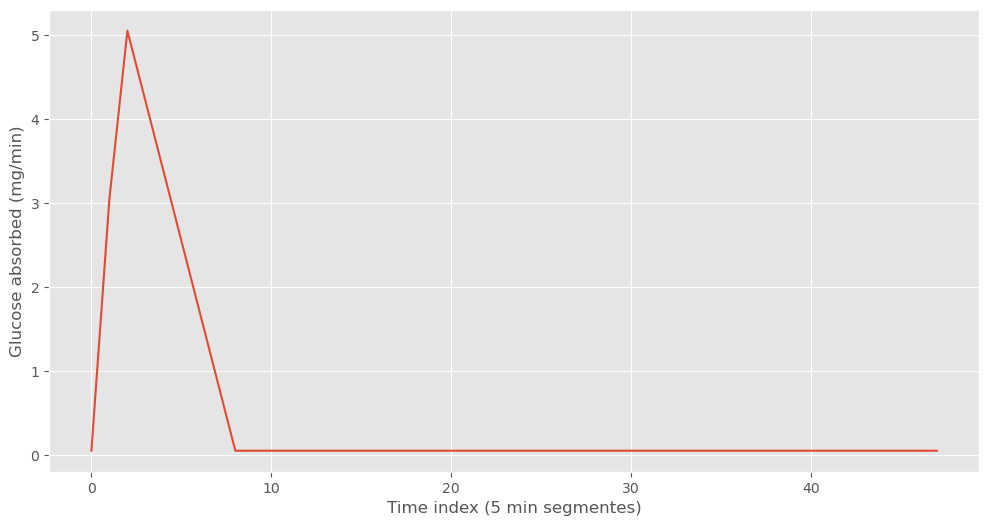

In [122]:
fig, ax = plt.subplots(figsize=(12,6))
plt.xlabel("Time index (5 min segmentes)")
plt.ylabel("Glucose absorbed (mg/min)")
plt.plot(carbohydrate_curve)

# Apply Curves to Data

In [123]:
def apply_glucose_curve(input_data):
    data = input_data.copy()
    carbs = data['Carb']
    carbs = carbs.reset_index()
    points = carbs[carbs['Carb'] > 0]
    indices = np.array(points.index)
    carbs['Carb'].values[:] = 0
    for index in indices:
        size = points['Carb'][index]
        curve_points = glucose_absorption_curve(size)
        end = index + len(curve_points)
        curve_end = len(curve_points)
        if (end > len(carbs)):
            curve_end = len(carbs) - index
        end_index = end if (end < len(carbs)) else len(carbs)
        carbs['Carb'][index:end_index] += curve_points[0:curve_end]
    carbs = carbs.set_index('ts')
    data['Carb'] = carbs['Carb']
    return data

In [124]:
def apply_insulin_curve(input_data):
    data = input_data.copy()
    insulin = data['Short']
    insulin = insulin.reset_index()
    points = insulin[insulin['Short'] > 0]
    indices = np.array(points.index)
    insulin['Short'].values[:] = 0
    for index in indices:
        size = points['Short'][index]
        curve_points = short_acting_insulin_curve(size)
        end = index + len(curve_points)
        curve_end = len(curve_points)
        if (end > len(insulin)):
            curve_end = len(insulin) - index
        end_index = end if (end < len(insulin)) else len(insulin)
        insulin['Short'][index:end_index] += curve_points[0:curve_end]
    insulin = insulin.set_index('ts')
    data['Short'] = insulin['Short']
    return data

In [125]:
def fill_in_basal(input_data):
    data = input_data.copy()
    basal = data['Long']
    basal = basal.reset_index()
    points = basal[basal['Long'] > 0]
    indices = np.array(points.index)
    for i in range(0, len(indices), 1):
        cur_index = indices[i]
        value = points['Long'][cur_index]
        next_index = 0
        if i == len(indices)-1:
            next_index = len(basal)
        else:
            next_index = indices[i+1]
        size = next_index - cur_index
        basal['Long'][cur_index:next_index] = np.full(size, value)
    basal = basal.set_index('ts')
    data['Long'] = basal['Long']
    return data

In [126]:
# Apply insulin Curves
train_570 = apply_insulin_curve(train_570)
test_570 = apply_insulin_curve(test_570)
train_588 = apply_insulin_curve(train_588)
test_588 = apply_insulin_curve(test_588)
train_563 = apply_insulin_curve(train_563)
test_563 = apply_insulin_curve(test_563)

In [127]:
# Apply Glucose Curves
train_570 = apply_glucose_curve(train_570)
test_570 = apply_glucose_curve(test_570)
train_588 = apply_glucose_curve(train_588)
test_588 = apply_glucose_curve(test_588)
train_563 = apply_glucose_curve(train_563)
test_563 = apply_glucose_curve(test_563)

In [128]:
# Fill in Bolus
train_570 = fill_in_basal(train_570)
test_570 = fill_in_basal(test_570)
train_588 = fill_in_basal(train_588)
test_588 = fill_in_basal(test_588)
train_563 = fill_in_basal(train_563)
test_563 = fill_in_basal(test_563)

# See Curves

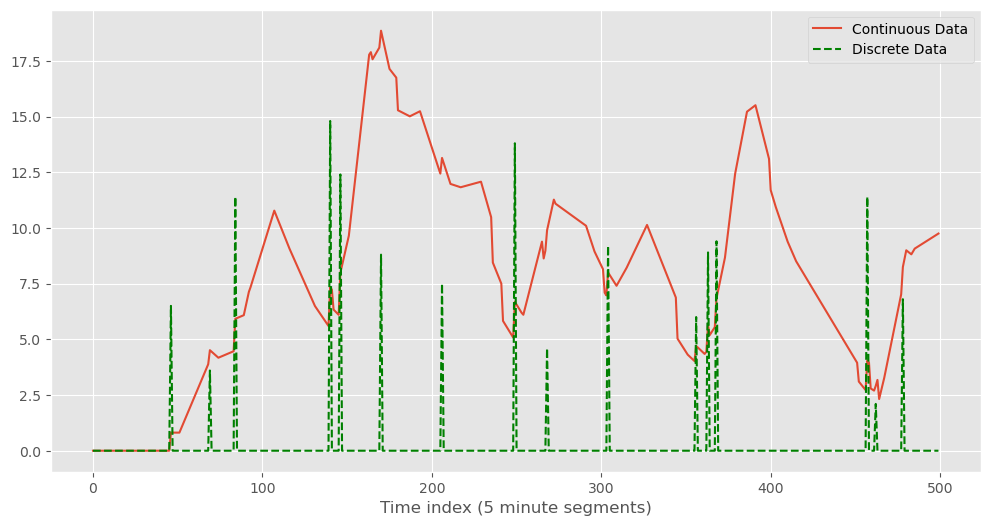

In [132]:
fig, ax = plt.subplots(figsize=(12,6))
plt.xlabel("Time index (5 minute segments)")
plt.plot(list(range(500)), test_563['Short'][0:500], label='Continuous Data')
plt.plot(list(range(500)), testing2['Short'][0:500], label='Discrete Data', linestyle='dashed', c='g')
plt.legend()
plt.show()

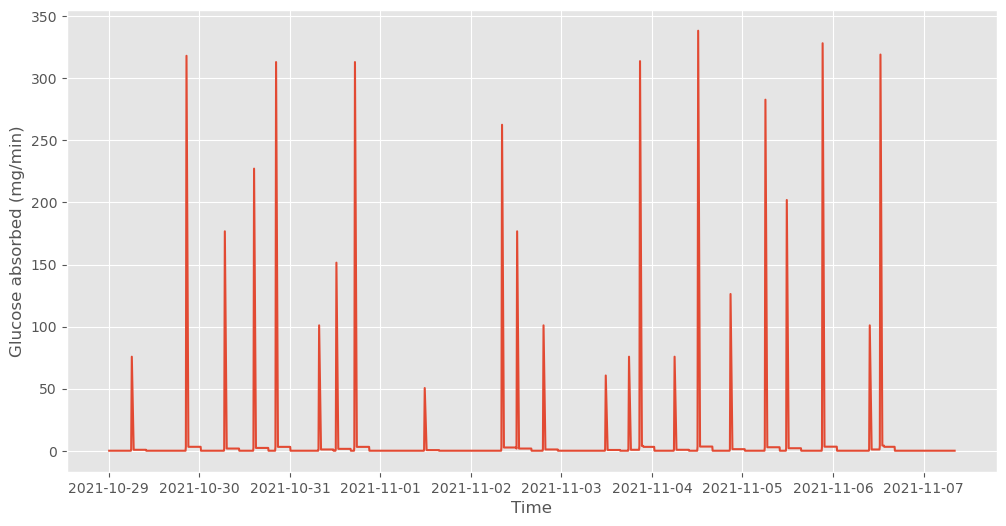

In [48]:
fig, ax = plt.subplots(figsize=(12,6))
plt.xlabel("Time")
plt.ylabel("Glucose absorbed (mg/min)")
plt.plot(test_563['Carb'])

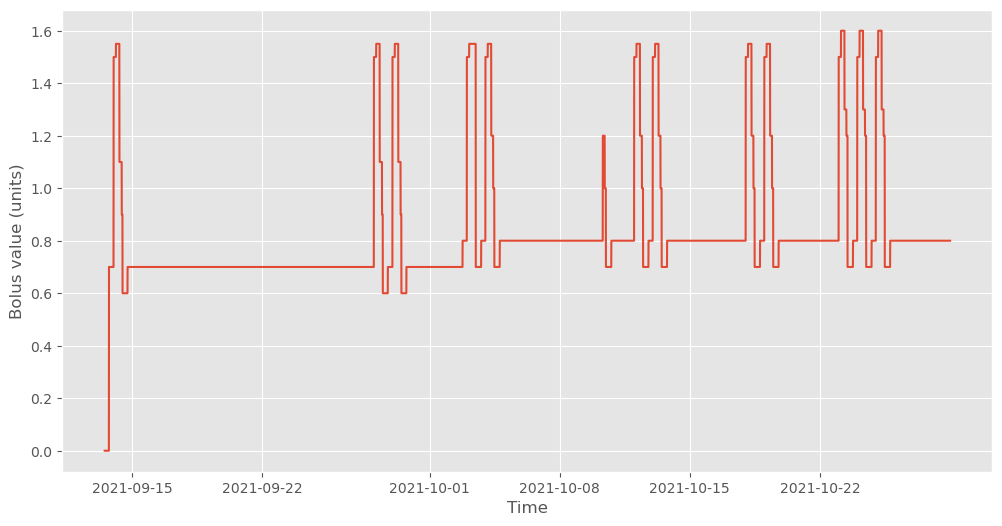

In [133]:
fig, ax = plt.subplots(figsize=(12,6))
plt.xlabel("Time")
plt.ylabel("Bolus value (units)")
plt.plot(train_563['Long'])

# Save Processed Data

In [69]:
train_570 = train_570.to_csv(processed + 'train_570.csv')
test_570 = test_570.to_csv(processed + 'test_570.csv')
train_588 = train_588.to_csv(processed + 'train_588.csv')
test_588 = test_588.to_csv(processed + 'test_588.csv')
train_563 = train_563.to_csv(processed + 'train_563.csv')
test_563 = test_563.to_csv(processed + 'test_563.csv')